# Flower Recognition

## [1] 데이터 로딩

In [115]:
# 모듈 로딩
import os
print(os.listdir('C:/Users/ss/Downloads/archive/flowers'))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [116]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adagrad

from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

import cv2                  
import numpy as np  

from tqdm import tqdm # 진행률 프로세스바(반복되는 객체 tqdm() 감싸기)
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

In [117]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='C:/Users/ss/Downloads/archive/flowers/daisy'
FLOWER_SUNFLOWER_DIR='C:/Users/ss/Downloads/archive/flowers/sunflower'
FLOWER_TULIP_DIR='C:/Users/ss/Downloads/archive/flowers/tulip'
FLOWER_DANDI_DIR='C:/Users/ss/Downloads/archive/flowers/dandelion'
FLOWER_ROSE_DIR='C:/Users/ss/Downloads/archive/flowers/rose'

In [118]:
# flower name 반환
def assign_label(img,flower_type):
    return flower_type

In [119]:
# train 데이터 만들기
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR), desc=flower_type):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR) # 경로, img파일 color로 불러들이기
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [120]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

Daisy: 100%|████████████████████████████████████████████████████████████████████████| 764/764 [00:01<00:00, 542.22it/s]

764


In [121]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

Sunflower: 100%|████████████████████████████████████████████████████████████████████| 733/733 [00:01<00:00, 481.49it/s]

1497


In [122]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

Tulip: 100%|████████████████████████████████████████████████████████████████████████| 984/984 [00:01<00:00, 578.43it/s]

2481


In [123]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

Dandelion: 100%|██████████████████████████████████████████████████████████████████| 1052/1052 [00:01<00:00, 599.98it/s]

3533


In [124]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

Rose: 100%|█████████████████████████████████████████████████████████████████████████| 784/784 [00:01<00:00, 620.95it/s]

4317


### [1-1] Random Image 시각화

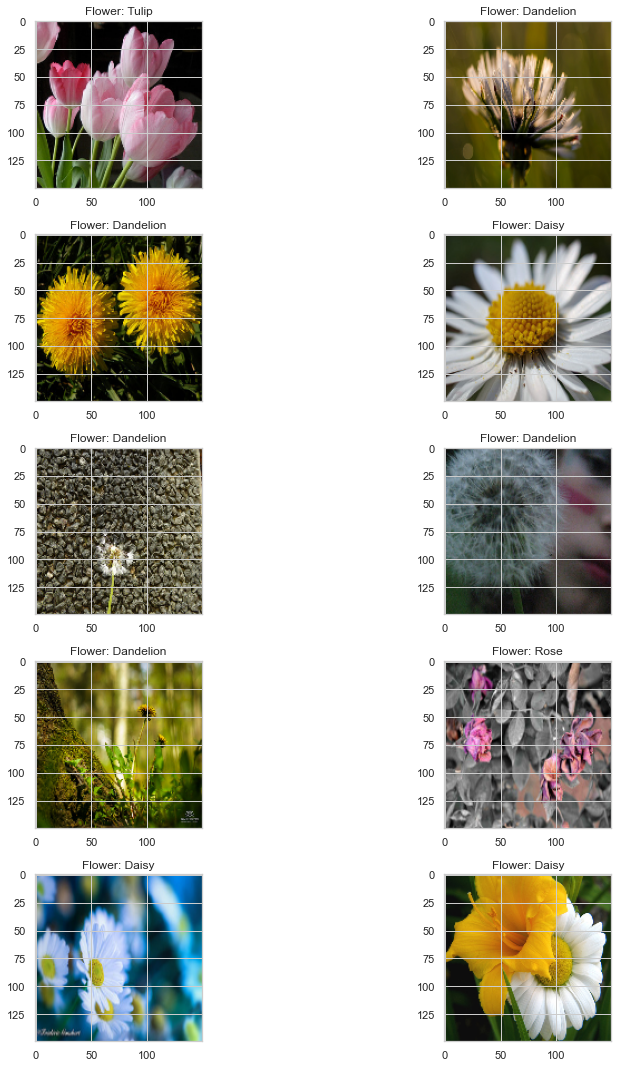

In [125]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z)) # 0~len(Z) 사이 난수 생성
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

## [2] 데이터 전처리

### [2-1] OneHotEncoder

In [126]:
OHE = OneHotEncoder(sparse=False)
Z = np.array(Z).reshape(-1,1)
Y = OHE.fit_transform(Z)
# X numpy 배열로 변경, 스케일링
X = np.array(X)
X = X/255

In [127]:
X.shape, Y.shape

((4317, 150, 150, 3), (4317, 5))

### [2-2] 데이터 나누기

In [128]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [129]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.2,random_state=42)

In [130]:
x_train.shape, x_test.shape, x_val.shape

((2762, 150, 150, 3), (864, 150, 150, 3), (691, 150, 150, 3))

### [2-3] Random seed Setting

In [131]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

## [3] 모델 생성

In [132]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 
model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

### [3-1] ReduceLROnPlateau(callback)

In [133]:
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

### [3-2] 이미지 전처리

In [134]:
# CNN 모델의 성능을 높이면서 오버피팅을 극복할 수 있는 가장 좋고 근본적인 해결책은 학습 데이터의 다양성을 늘리는 것
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=15,  # 회전반경 45도 이내 설정
        zoom_range = 0.1, # 확대 범위 
        width_shift_range=0.2,  # 너비 반경 20%
        height_shift_range=0.2,  # 높이 반경 20%
        horizontal_flip=True,  # 수평반전
        vertical_flip=True)  # 수직반전

In [135]:
datagen.fit(x_train)

In [136]:
x_train.shape

(2762, 150, 150, 3)

In [137]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [138]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 18, 18, 96)      

## [4] 모델 학습

In [ ]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val,y_val),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/50
21/21 [==============================] - 56s 3s/step - loss: 1.5528 - accuracy: 0.2855 - val_loss: 1.3669 - val_accuracy: 0.3965
Epoch 2/50
21/21 [==============================] - 60s 3s/step - loss: 1.2676 - accuracy: 0.4468 - val_loss: 1.1455 - val_accuracy: 0.5123
Epoch 3/50
21/21 [==============================] - 56s 3s/step - loss: 1.1877 - accuracy: 0.5053 - val_loss: 1.0956 - val_accuracy: 0.5543
Epoch 4/50
21/21 [==============================] - 56s 3s/step - loss: 1.0912 - accuracy: 0.5626 - val_loss: 1.0094 - val_accuracy: 0.5745
Epoch 5/50
21/21 [==============================] - 56s 3s/step - loss: 1.0493 - accuracy: 0.5859 - val_loss: 1.0550 - val_accuracy: 0.5803
Epoch 6/50
21/21 [==============================] - 57s 3s/step - loss: 0.9869 - accuracy: 0.6147 - val_loss: 1.0599 - val_accuracy: 0.5673
Epoch 7/50
21/21 [==============================] - 56s 3s/step - loss: 0.9524 - accuracy: 0.6260 - val_loss: 0.9912 - val_accuracy: 0.6179
Epoch 8/50
21/21 [==

In [ ]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = History.history['accuracy']
train_loss = History.history['loss']
val_acc = History.history['val_accuracy']
val_loss = History.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Val Accuracy')
ax[0].set_title('Training & Val Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Val Loss')
ax[1].set_title('Training & Val Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

## [5] 모델 예측

In [ ]:
pred = model.predict(x_test)
np.round(pred)

In [ ]:
a = 0
for i in range(len(x_test)):
    if int(np.round(pred)[i].argmax()) == int(y_test[i].argmax()):
        a += 1

In [ ]:
a/y_test.shape[0]

### [5-1] test data 예측

In [ ]:
# daisy,sunflower,tulip,dandelion,rose
for i in range(0,10):
  l=rn.randint(0,x_test.shape[0])
  plt.imshow(x_test[l].reshape(150,150,3))
  if int(np.round(pred[l])[1]) == 1:
      plt.title(f'Prediction Result : {np.round(pred[l])} : dandelion')
  elif int(np.round(pred[l])[0]) == 1:
      plt.title(f'Prediction Result : {np.round(pred[l])} : daisy')
  elif int(np.round(pred[l])[2]) == 1:
      plt.title(f'Prediction Result : {np.round(pred[l])} : rose')
  elif int(np.round(pred[l])[3]) == 1:
      plt.title(f'Prediction Result : {np.round(pred[l])} : sunflower')
  else:
    plt.title(f'Prediction Result : {np.round(pred[l])} : tulip')
  plt.show()

In [ ]:
pre_test = []
for img in os.listdir('C:/Users/ss/Desktop/flower_test'):
        
        path = os.path.join('C:/Users/ss/Desktop/flower_test',img)
        img = cv2.imread(path,cv2.IMREAD_COLOR) # 경로, img파일 color로 불러들이기
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (150,150))
        pre_test.append(np.array(img))

In [ ]:
model.predict(pre_test[0].reshape(-1,150,150,3))

In [ ]:
np.round(model.predict(pre_test[0].reshape(-1,150,150,3)))[0][0]

### [5-2] 임의의 image 예측

In [ ]:
for i in range(0,10):
  test = np.round(model.predict(pre_test[i].reshape(-1,150,150,3)))
  if int(test[0][0]) == 1:
    plt.imshow(pre_test[i])
    plt.title('daisy')
  
  elif int(test[0][1]) == 1:
    plt.imshow(pre_test[i])
    plt.title('dandelion')

  elif int(test[0][2]) == 1:
    plt.imshow(pre_test[i])
    plt.title('rose')
  
  elif int(test[0][3]) == 1:
    plt.imshow(pre_test[i])
    plt.title('sunflower')
  
  else:
    plt.imshow(pre_test[i])
    plt.title('tulip')
    
  plt.show()